In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter
import seaborn as sns
import torch
import torchvision.models as models
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# TWORZY WYKRES PUNKTOWY 3D KLASTRÓW

pd.set_option('display.max_rows', None)

def description(data):
    '''
    Returns the DataFrame representing a thorough description of the data.
    '''
    dtypes = data.dtypes
    counts = data.apply(lambda col: col.count())
    nulls = data.apply(lambda col: col.isnull().sum())
    nan_ratio = nulls / counts
    uniques = data.apply(lambda col: col.unique())
    n_uniques = data.apply(lambda col: col.nunique())
    #maxs = data.apply(lambda col: col.max())
    #mins = data.apply(lambda col: col.min())

    cols = {'dtypes':dtypes, 'counts':counts, 'nulls' : nulls, 'nan_ratio': nan_ratio,
            'n_uniques':n_uniques, 'uniques':uniques}
    return pd.DataFrame(data=cols)

def plot_clusters3d(cluster_groups, cluster_col, title, colorscale=None, legend=True):
    '''
    Creates a 3D scatterplot of clusters. The color of data points is determined by colorscale parameter.
    '''
    # Create a figure.
    fig = go.Figure()

    # Plot scatter points for each cluster.
    for cluster in cluster_groups[cluster_col].unique():
        # Get the data points for that specific cluster.
        cluster_group = cluster_groups[cluster_groups[cluster_col] == cluster]
        # Add some scatter belonging to the cluster to the plot.
        trace = go.Scatter3d(x=cluster_group[0], y=cluster_group[1], z=cluster_group[2],
                             mode='markers', marker=dict(size=4 ,opacity=0.8, colorscale=colorscale),
                             legendwidth=2, name=cluster,)
        fig.add_trace(trace)

    # Add title and legend.
    fig.update_layout(showlegend=legend, width=700, height=600,
                      legend=dict(font=dict(size=20), itemsizing="constant", ),
                      title=dict(text=title, x=0.5))
    fig.show()

#**WCZYTYWANIE I ANALIZA DANYCH**

In [5]:
# when on kaggle
#data = pd.read_csv(""/kaggle/input/cattells-16-personality-factors/16PF/"data.csv",delimiter="\t")

# when on local
#data = pd.read_csv("data.csv",delimiter="\t")

#when google collab
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv",delimiter="\t")

In [6]:
# USUWANIE KOLUMN

columns_to_drop = ['age', 'gender', 'accuracy', 'country', 'source', 'elapsed']
data = data.drop(columns=columns_to_drop)

print(data.head())

   A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  ...  P1  P2  P3  P4  P5  P6  P7  \
0   1   4   2   3   3   2   3   4   4    3  ...   5   5   5   4   4   5   1   
1   4   3   4   3   4   4   4   4   2    2  ...   4   4   4   2   3   2   3   
2   3   4   4   4   4   4   4   3   2    2  ...   3   3   4   2   4   2   2   
3   4   5   4   4   4   3   3   2   2    2  ...   4   2   2   2   3   4   2   
4   4   0   4   4   4   3   5   1   2    4  ...   4   3   4   3   4   3   4   

   P8  P9  P10  
0   2   5    2  
1   2   2    2  
2   3   3    3  
3   3   4    4  
4   2   3    2  

[5 rows x 163 columns]


In [7]:
", ".join(data.columns.tolist())

'A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, B1, B2, B3, B4, B5, B6, B7, B8, B9, B10, B11, B12, B13, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, G1, G2, G3, G4, G5, G6, G7, G8, G9, G10, H1, H2, H3, H4, H5, H6, H7, H8, H9, H10, I1, I2, I3, I4, I5, I6, I7, I8, I9, I10, J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, K1, K2, K3, K4, K5, K6, K7, K8, K9, K10, L1, L2, L3, L4, L5, L6, L7, L8, L9, L10, M1, M2, M3, M4, M5, M6, M7, M8, M9, M10, N1, N2, N3, N4, N5, N6, N7, N8, N9, N10, O1, O2, O3, O4, O5, O6, O7, O8, O9, O10, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10'

In [98]:
description(data)

dtypes  counts  nulls  nan_ratio  n_uniques  \
A1         int64   49159      0   0.000000          6   
A2         int64   49159      0   0.000000          6   
A3         int64   49159      0   0.000000          6   
A4         int64   49159      0   0.000000          6   
A5         int64   49159      0   0.000000          6   
...          ...     ...    ...        ...        ...   
gender     int64   49159      0   0.000000          4   
accuracy   int64   49159      0   0.000000        113   
country   object   49142     17   0.000346        159   
source     int64   49159      0   0.000000          6   
elapsed    int64   49159      0   0.000000       4587   

                                                    uniques  
A1                                       [1, 4, 3, 2, 5, 0]  
A2                                       [4, 3, 5, 0, 2, 1]  
A3                                       [2, 4, 5, 3, 1, 0]  
A4                                       [3, 4, 5, 1, 2, 0]  
A5                                       [3, 4, 2, 5, 1, 0]  
...                                                     ...  
gender                                         [1, 2, 0, 3]  
accuracy  [92, 100, 80, 93, 87, 78, 95, 82, 90, 54, 70, ...  
country   [US, NZ, IT, TR, PH, NL, IN, FI, CA, AU, PT, Z...  
source                                   [6, 1, 3, 5, 2, 4]  
elapsed   [914, 891, 903, 806, 1826, 669, 717, 567, 651,...  

[169 rows x 6 columns]

In [99]:
pd.set_option('display.max_rows', 50)

null_rows = data[data['country'].isnull()]
null_rows

A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  ...  P7  P8  P9  P10  age  \
16600   3   4   4   2   4   2   2   2   4    4  ...   4   4   4    3   26   
18248   5   1   5   1   1   1   5   5   5    2  ...   5   1   5    1   53   
19884   2   4   2   4   5   2   4   2   2    2  ...   4   4   4    3   40   
29619   4   4   4   5   5   5   4   1   1    1  ...   4   3   4    4   23   
37107   4   4   4   4   3   2   4   2   2    4  ...   4   2   4    4   60   
40277   4   4   4   4   4   4   4   4   2    3  ...   2   2   4    2   28   
40342   5   2   5   4   5   4   5   1   1    4  ...   5   5   1    1   33   
43545   5   5   5   4   5   4   5   4   1    1  ...   2   2   5    5   49   
46365   3   4   4   4   4   5   4   4   1    1  ...   1   2   4    4   44   
46960   5   5   5   5   5   5   5   1   1    5  ...   2   2   4    3   49   
47135   5   4   5   5   5   3   5   3   5    1  ...   3   2   4    3   48   
47404   5   5   5   4   5   5   4   1   2    1  ...   2   5   4    4   16   
48211   4   4   4   3   5   4   4   3   3    2  ...   3   3   4    4   22   
48327   1   1   1   1   1   1   1   1   5    3  ...   2   1   1    1   15   
48617   4   4   4   5   4   3   4   2   2    2  ...   3   3   4    4   21   
48908   3   3   3   2   4   4   2   1   4    2  ...   3   3   4    4   51   
49140   5   0   4   4   5   4   5   2   1    2  ...   2   2   4    4   29   

       gender  accuracy  country  source  elapsed  
16600       2       100      NaN       1      904  
18248       1       100      NaN       1      743  
19884       1        85      NaN       6      611  
29619       1        87      NaN       1     1233  
37107       1        85      NaN       6     1013  
40277       1        98      NaN       6     1071  
40342       2       100      NaN       1     1255  
43545       2       100      NaN       1      722  
46365       2        85      NaN       1     1229  
46960       2       100      NaN       6     1224  
47135       2       100      NaN       6      509  
47404       1       100      NaN       1      962  
48211       1        90      NaN       6     1502  
48327       1       100      NaN       1      753  
48617       1        90      NaN       1      321  
48908       2        98      NaN       2      593  
49140       2       100      NaN       1      634  

[17 rows x 169 columns]

In [100]:
data = data.drop(null_rows.index,axis=0)
# Check if null rows have been deleted.
data[data['country'].isnull()]

Empty DataFrame
Columns: [A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, B1, B2, B3, B4, B5, B6, B7, B8, B9, B10, B11, B12, B13, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, G1, G2, G3, G4, G5, G6, G7, G8, G9, G10, H1, H2, H3, H4, H5, H6, H7, H8, H9, H10, I1, I2, I3, I4, I5, I6, I7, I8, I9, I10, J1, J2, J3, J4, J5, J6, J7, ...]
Index: []

[0 rows x 169 columns]

## **DATA PREPROCESSING**

In [101]:
# Encoding the categorical features
label_encoder = LabelEncoder()
data['country_encoded'] = label_encoder.fit_transform(data['country'].astype(str))
data = data.drop(['country'], axis=1)

In [12]:
# Standard scaling all features
std = StandardScaler()
data_std = pd.DataFrame(std.fit_transform(data), columns=data.columns)
data_std

A1        A2        A3        A4        A5        A6        A7  \
0     -2.322236  0.196851 -1.629455 -0.593522 -0.834733 -1.711358 -0.901475   
1      0.307141 -0.747339  0.181935 -0.593522  0.172796  0.337711  0.134857   
2     -0.569318  0.196851  0.181935  0.343378  0.172796  0.337711  0.134857   
3      0.307141  1.141041  0.181935  0.343378  0.172796 -0.686823 -0.901475   
4      0.307141 -3.579909  0.181935  0.343378  0.172796 -0.686823  1.171189   
...         ...       ...       ...       ...       ...       ...       ...   
49154 -2.322236 -2.635719 -2.535149 -2.467322 -2.849791 -2.735892 -2.974139   
49155  0.307141  1.141041  0.181935  0.343378  0.172796 -0.686823  1.171189   
49156 -1.445777  0.196851 -1.629455 -0.593522 -0.834733 -0.686823  0.134857   
49157  0.307141  0.196851  0.181935  0.343378  0.172796  0.337711  0.134857   
49158  0.307141  1.141041  0.181935  1.280278  1.180325  0.337711  1.171189   

             A8        A9       A10  ...        P1        P2        P3  \
0      0.891564  1.782348  0.529182  ...  1.673574  1.873855  1.732857   
1      0.891564 -0.134632 -0.397343  ...  0.860191  1.067990  0.875739   
2      0.033748 -0.134632 -0.397343  ...  0.046809  0.262125  0.875739   
3     -0.824068 -0.134632 -0.397343  ...  0.860191 -0.543741 -0.838496   
4     -1.681884 -0.134632  1.455707  ...  0.860191  0.262125  0.875739   
...         ...       ...       ...  ...       ...       ...       ...   
49154 -1.681884 -1.093122 -1.323869  ... -1.579957 -1.349606 -1.695614   
49155  0.033748 -0.134632  0.529182  ...  0.046809  0.262125  0.018621   
49156  0.891564 -0.134632  1.455707  ... -0.766574 -0.543741  0.875739   
49157  0.891564 -1.093122  0.529182  ... -0.766574 -0.543741  0.018621   
49158  0.033748 -1.093122 -0.397343  ... -0.766574 -0.543741 -1.695614   

             P4        P5        P6        P7        P8        P9       P10  
0      0.783038  1.372322  1.647869 -1.536946 -0.769505  1.228795 -1.307738  
1     -0.971725  0.391028 -0.947863  0.173792 -0.769505 -1.489435 -1.307738  
2     -0.971725  1.372322 -0.947863 -0.681577  0.057013 -0.583359 -0.414452  
3     -0.971725  0.391028  0.782625 -0.681577  0.057013  0.322718  0.478833  
4     -0.094344  1.372322 -0.082619  1.029161 -0.769505 -0.583359 -1.307738  
...         ...       ...       ...       ...       ...       ...       ...  
49154 -1.849106 -1.571558 -1.813107 -1.536946 -1.596024 -2.395512 -2.201023  
49155  0.783038 -0.590265 -0.082619  0.173792  0.883532  0.322718  0.478833  
49156  0.783038  0.391028 -0.947863  0.173792  0.883532  1.228795  0.478833  
49157 -0.094344  1.372322 -0.947863 -0.681577  0.883532  1.228795  0.478833  
49158 -0.971725 -0.590265 -0.947863 -1.536946  0.883532  0.322718  1.372119  

[49159 rows x 163 columns]

In [102]:
# Reducing dimensions to 3.
pca = PCA(n_components=3, random_state=12)
data_reduced = pd.DataFrame(pca.fit_transform(data_std),)

data_reduced.head()

0         1         2
0  3.852143 -3.318777  4.614395
1  3.266473 -0.022739  2.430577
2  3.054036 -0.057057  3.069116
3  2.709945 -0.705011  1.756189
4  1.189900  0.353530  0.780617

In [14]:
# Create a scatterplot.
trace = go.Scatter3d(x=data_reduced[0], y=data_reduced[1], z=data_reduced[2], mode='markers',
                     marker=dict(size=3 ,opacity=0.8, color='green'),)

layout = go.Layout(title=dict(text='3D Data', x=0.5), width=600, height=600)
fig = go.Figure(data=[trace], layout=layout)

fig.show()

## **CLUSTERING**

### **K-Means**

FInding optimal number of clusters.

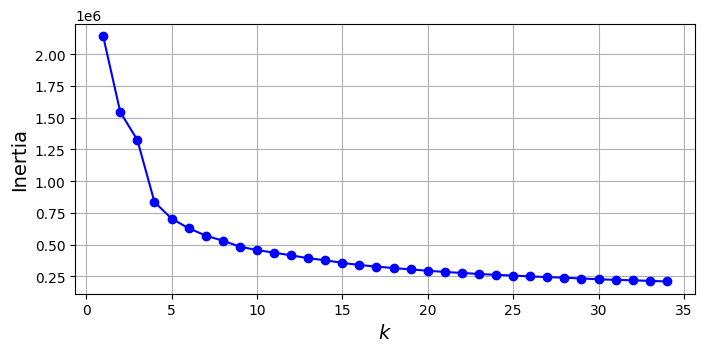

In [15]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=12, n_init='auto').fit(data_reduced) for k in range(1,35)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1,35), inertias, "bo-")

# plt.annotate('Elbow?',xy=(4, inertias[3]), xytext=(0.45, 0.55), textcoords='figure fraction',
#              fontsize=16, arrowprops=dict(facecolor='black', shrink=0.1))

plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.grid(True)

In [16]:
silhouette_scores = [silhouette_score(data_reduced, model.labels_, random_state=12)
                     for model in kmeans_per_k[1:15]]

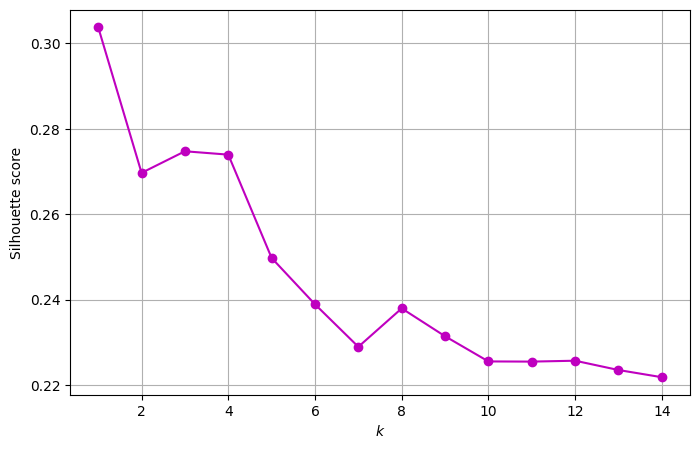

In [17]:
plt.figure(figsize=(8,5))
plt.plot(range(1,15),silhouette_scores,'mo-')
plt.xlabel("$k$", )
plt.ylabel("Silhouette score", )
plt.grid(True)

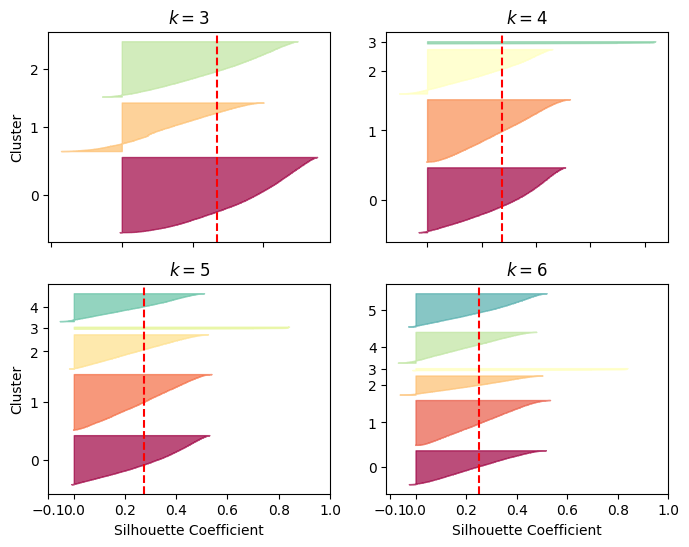

In [18]:
plt.figure(figsize=(8,6))

for k in (3,4,5,6):
    plt.subplot(2,2,k-2)

    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coeffs = silhouette_samples(data_reduced, y_pred)

    padding = len(data_reduced) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]   # cluster coeffs
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color,
                          edgecolor=color, alpha=0.7)

        ticks.append(pos + len(coeffs)//2)
        pos +=len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if k in (3,5):
        plt.ylabel("Cluster")
    if k in (5,6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k-2], color='red', linestyle='--')
    plt.title("$k={}$".format(k),)

Fitting the data.

In [20]:
data_copy=data.copy()

In [21]:
kmeans = KMeans(n_clusters=5, random_state=12, n_init='auto')

data_copy['kmeans_cluster'] = kmeans.fit_predict(data_reduced) # Fit the model and predict clusters
data_copy['kmeans_cluster'] = data_copy['kmeans_cluster'].astype('category')

In [22]:
temp = data_reduced.copy()
cluster_col = 'kmeans_cluster'
temp[cluster_col] = data_copy[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (KMeans)')

<ipython-input-23-c5968389c78c>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-23-c5968389c78c>:1: UserWarning:

The palette list has more values (6) than needed (5), which may not be intended.



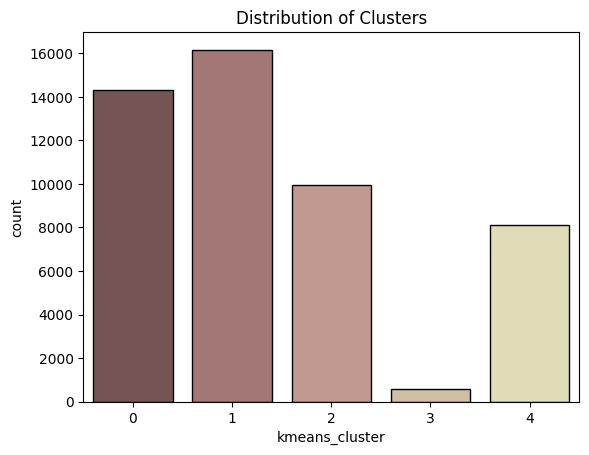

In [23]:
sns.countplot(x=data_copy['kmeans_cluster'], palette=sns.color_palette("pink"),edgecolor='black')
plt.title('Distribution of Clusters');

In [24]:
kmeans = KMeans(n_clusters=16, random_state=12, n_init='auto')

data_copy['kmeans_cluster'] = kmeans.fit_predict(data_reduced) # Fit the model and predict clusters
data_copy['kmeans_cluster'] = data_copy['kmeans_cluster'].astype('category')

In [25]:
temp = data_reduced.copy()
cluster_col = 'kmeans_cluster'
temp[cluster_col] = data_copy[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (KMeans)')

<ipython-input-26-c5968389c78c>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-26-c5968389c78c>:1: UserWarning:


The palette list has fewer values (6) than needed (16) and will cycle, which may produce an uninterpretable plot.



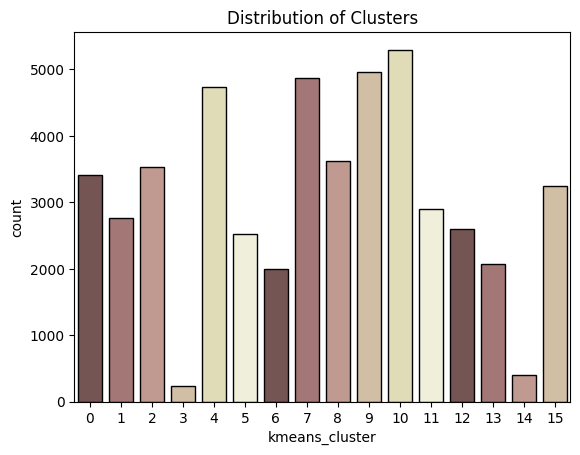

In [26]:
sns.countplot(x=data_copy['kmeans_cluster'], palette=sns.color_palette("pink"),edgecolor='black')
plt.title('Distribution of Clusters');

## Further steps:
- Finding feature importances using clf for Kmeans
- Analyzing the most important columns vs. generated by KMeans labels
- BIRCH for clustering

In [27]:
data_copy

A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  ...  P2  P3  P4  P5  P6  P7  \
0       1   4   2   3   3   2   3   4   4    3  ...   5   5   4   4   5   1   
1       4   3   4   3   4   4   4   4   2    2  ...   4   4   2   3   2   3   
2       3   4   4   4   4   4   4   3   2    2  ...   3   4   2   4   2   2   
3       4   5   4   4   4   3   3   2   2    2  ...   2   2   2   3   4   2   
4       4   0   4   4   4   3   5   1   2    4  ...   3   4   3   4   3   4   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..  ..  ..   
49154   1   1   1   1   1   1   1   1   1    1  ...   1   1   1   1   1   1   
49155   4   5   4   4   4   3   5   3   2    3  ...   3   3   4   2   3   3   
49156   2   4   2   3   3   3   4   4   2    4  ...   2   4   4   3   2   3   
49157   4   4   4   4   4   4   4   4   1    3  ...   2   3   3   4   2   2   
49158   4   5   4   5   5   4   5   3   1    2  ...   2   1   2   2   2   1   

       P8  P9  P10  kmeans_cluster  
0       2   5    2              11  
1       2   2    2               4  
2       3   3    3               4  
3       3   4    4               4  
4       2   3    2               4  
...    ..  ..  ...             ...  
49154   1   1    1               3  
49155   4   4    4              10  
49156   4   5    4               9  
49157   4   5    4              15  
49158   4   4    5               5  

[49159 rows x 164 columns]

In [28]:
data_copy.tail()

A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  ...  P2  P3  P4  P5  P6  P7  \
49154   1   1   1   1   1   1   1   1   1    1  ...   1   1   1   1   1   1   
49155   4   5   4   4   4   3   5   3   2    3  ...   3   3   4   2   3   3   
49156   2   4   2   3   3   3   4   4   2    4  ...   2   4   4   3   2   3   
49157   4   4   4   4   4   4   4   4   1    3  ...   2   3   3   4   2   2   
49158   4   5   4   5   5   4   5   3   1    2  ...   2   1   2   2   2   1   

       P8  P9  P10  kmeans_cluster  
49154   1   1    1               3  
49155   4   4    4              10  
49156   4   5    4               9  
49157   4   5    4              15  
49158   4   4    5               5  

[5 rows x 164 columns]

# **FEATURE IMPORTANCE**

## **First try**

In [ ]:
# Extract feature importances from the ET model and plot them.
# imp_features = pd.Series(clf.feature_importances_,
#                          index = X_train.columns).sort_values(ascending=False)
# plt.figure(figsize=(7,6))
# sns.barplot(x=imp_features, y=imp_features.index, palette='winter')
# plt.title('Feature Importances', fontsize=14)
# plt.xlabel('Importance Score')

### **Neural Network Classifier**

Using classification neural network on clustered dataset.

In [103]:
# data_copy without labels
classification_data = data_copy.drop(["kmeans_cluster"], axis=1)

# labels
classification_labels = data_copy["kmeans_cluster"]

In [104]:
# We should have standarized data for machine learning model

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
classification_data = scaler.fit_transform(classification_data)

Creating basic neural network from scratch

In [105]:
import tensorflow as tf

cl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [106]:
cl_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [107]:
# Find the best lr while fitting the model

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

In [108]:
cl_model.fit(classification_data, classification_labels, epochs=15, callbacks=[lr_scheduler])

Epoch 1/15
1537/1537 [==============================] - 8s 4ms/step - loss: 2.0884 - accuracy: 0.2854 - lr: 0.0010
Epoch 2/15
1537/1537 [==============================] - 4s 3ms/step - loss: 1.6024 - accuracy: 0.4389 - lr: 0.0011
Epoch 3/15
1537/1537 [==============================] - 4s 3ms/step - loss: 1.4308 - accuracy: 0.4854 - lr: 0.0013
Epoch 4/15
1537/1537 [==============================] - 5s 3ms/step - loss: 1.2768 - accuracy: 0.5408 - lr: 0.0014
Epoch 5/15
1537/1537 [==============================] - 4s 3ms/step - loss: 1.1834 - accuracy: 0.5683 - lr: 0.0016
Epoch 6/15
1537/1537 [==============================] - 4s 3ms/step - loss: 1.1333 - accuracy: 0.5799 - lr: 0.0018
Epoch 7/15
1537/1537 [==============================] - 5s 4ms/step - loss: 1.1001 - accuracy: 0.5871 - lr: 0.0020
Epoch 8/15
1537/1537 [==============================] - 5s 3ms/step - loss: 1.0783 - accuracy: 0.5909 - lr: 0.0022
Epoch 9/15
1537/1537 [==============================] - 4s 3ms/step - loss: 1.06

Weight-based methods:
Weight-based methods consider the weights or connections between the neurons in the neural network to estimate feature importance. Features with higher weights contribute more to the final predictions of the model.
If your neural network model is a fully connected network (dense layers), you can extract the weights from the model and calculate feature importance as follows:

In [109]:
# Get the weights from the model's layers
weights = cl_model.get_weights()

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights[0]), axis=1)


In [110]:
len(feature_importance)

163

In [111]:
# get 5 most important features and print them
most_important_features = np.argsort(feature_importance)[-5:]

most_important_features

array([42, 32, 67, 19, 66])

In [112]:
# get the names of the most important features
data.columns[most_important_features]


Index(['D10', 'C10', 'G5', 'B10', 'G4'], dtype='object')

Gradient-based methods:
Gradient-based methods utilize the gradients of the network's output with respect to the input features to estimate their importance. A higher absolute gradient value indicates a greater impact on the network's output.
Let's assume you have a trained neural network model and a set of input data called X. You can calculate the feature importance using the gradient-based method as follows:

In [113]:
X = classification_data # Load your input data

# Compute gradients of the output with respect to the input
input_tensor = tf.convert_to_tensor(X)
with tf.GradientTape() as tape:
 tape.watch(input_tensor)
 output = cl_model(input_tensor)
gradients = tape.gradient(output, input_tensor)

# Calculate feature importance as the absolute mean of the gradients
feature_importance = np.mean(np.abs(gradients.numpy()), axis=0)


In [114]:
len(feature_importance)

163

In [115]:
# get 5 most important features and print them
most_important_features = np.argsort(feature_importance)[-5:]

data.columns[most_important_features]

Index(['N9', 'G5', 'E1', 'G1', 'G4'], dtype='object')

### **Random Forest**

Use random forest (feature importance built-in)

In [116]:
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

# Assuming `data` is your original DataFrame and `labels` are the cluster labels
# Also assuming that your data is already standardized

num_clusters = classification_labels.nunique()

all_feature_importances = defaultdict(float)

# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=50, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance


In [117]:
# top 5 features across all clusters
sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 0.23293185797866867
G7: 0.18734035067278237
I4: 0.18291941531324948
F4: 0.18175941822495398
G4: 0.17773198569629164


## **Second try**

How does change in parameters impact change in feature importance list

### **Change in random forest main params**

#### n_estimators changing, using "gini"

In [118]:
# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=20, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

In [119]:
# top 5 features across all clusters
sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 0.5059029194639202
F4: 0.3983191466515474
G7: 0.35908650519436663
D8: 0.3556780722670046
I4: 0.35401886514731157


In [120]:
# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=30, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 0.7520492589224788
F4: 0.6071336278036904
I4: 0.5568654852934817
E8: 0.5521876616992724
D8: 0.5381449664631491


In [121]:
# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=40, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 0.9740674095115506
F4: 0.8062519792198951
I4: 0.7377335787648627
G7: 0.7293932492401236
E8: 0.7202731069925338


In [122]:
# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=50, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 1.206999267490219
F4: 0.9880113974448492
I4: 0.9206529940781122
G7: 0.9167335999129058
E8: 0.8851516984880663


In [123]:
# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=60, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 1.4338309271880312
F4: 1.1764854073687332
I4: 1.1019645293637315
G7: 1.1004853141373367
D8: 1.0421522398313712


In [124]:
# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=80, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 1.6585492789191145
F4: 1.358938738870011
G7: 1.2677046662665423
I4: 1.2669631771243595
N1: 1.209656815204666


Change criterion (we were using default - gini)

#### **n estimators changing - using entropy**

In [ ]:
# For each cluster
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=20, random_state=0, criterion="entropy")
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 2.1785761139691218
F4: 1.6245984332812675
G7: 1.5754844508092838
I4: 1.474318348995634
E8: 1.4733033792276293


In [ ]:
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=30, random_state=0, criterion="entropy")
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 2.5832223940244012
N6: 1.9867693500553485
elapsed: 1.9283951979188036
G7: 1.640008082437546
G5: 1.5992902940013844


In [ ]:
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=40, random_state=0, criterion="entropy")
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 2.9140391375698225
N6: 2.1822901939376496
elapsed: 2.0792629272766523
G7: 1.8428596919078661
G5: 1.787430371666089


In [ ]:
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=50, random_state=0, criterion="entropy")
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 3.242449766800394
N6: 2.3702381340107617
elapsed: 2.2295732231742855
G7: 2.0476842894885414
G5: 1.973107536259949


In [ ]:
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=60, random_state=0, criterion="entropy")
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 3.5522494284205277
N6: 2.553366111476127
elapsed: 2.3805787434293904
G7: 2.250197825587925
G5: 2.147866469755298


In [ ]:
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=80, random_state=0, criterion="entropy")
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 3.848084877077857
N6: 2.7069006584900595
elapsed: 2.53200827361626
G7: 2.437816055379192
N1: 2.337616566257689


Let's try with estimators = 150

In [ ]:
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=150, random_state=0, criterion="entropy")
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 4.355828990450199
N6: 2.974361224963592
elapsed: 2.8862974673367012
G7: 2.8002991148114003
N1: 2.7015189198385747


In [ ]:
for i in range(num_clusters):
    # Create binary target variable: 1 for current cluster, 0 for other clusters
    y = (classification_labels == i).astype(int)

    clf = RandomForestClassifier(n_estimators=150, random_state=0)
    clf.fit(classification_data, y)

    feature_importance = clf.feature_importances_

    # Add feature importance to the total
    for feature, importance in zip(data.columns, feature_importance):
        all_feature_importances[feature] += importance

sorted_features = sorted(all_feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Top 5 features across all clusters:")
for feature, importance in sorted_features[:5]:
    print(f"{feature}: {importance}")

Top 5 features across all clusters:
G1: 4.06278004340533
N6: 2.8490676244089967
elapsed: 2.7351888489852314
G7: 2.598411750524039
N1: 2.500613959246191


Top 5 features are still the same. Maybe let's change something in neural network classifier

### Change in neural network

# **Adding more layers, more neurons**

In [ ]:
import tensorflow as tf

cl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [ ]:
cl_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Find the best lr while fitting the model

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

In [ ]:
cl_model.fit(classification_data, classification_labels, epochs=15, callbacks=[lr_scheduler])

Epoch 1/15
761/761 [==============================] - 5s 3ms/step - loss: 1.1329 - accuracy: 0.6055 - lr: 0.0010
Epoch 2/15
761/761 [==============================] - 3s 4ms/step - loss: 0.3912 - accuracy: 0.8537 - lr: 0.0011
Epoch 3/15
761/761 [==============================] - 4s 6ms/step - loss: 0.2587 - accuracy: 0.9003 - lr: 0.0013
Epoch 4/15
761/761 [==============================] - 3s 4ms/step - loss: 0.2116 - accuracy: 0.9170 - lr: 0.0014
Epoch 5/15
761/761 [==============================] - 3s 4ms/step - loss: 0.1955 - accuracy: 0.9227 - lr: 0.0016
Epoch 6/15
761/761 [==============================] - 3s 4ms/step - loss: 0.1941 - accuracy: 0.9222 - lr: 0.0018
Epoch 7/15
761/761 [==============================] - 4s 6ms/step - loss: 0.1903 - accuracy: 0.9246 - lr: 0.0020
Epoch 8/15
761/761 [==============================] - 4s 5ms/step - loss: 0.1888 - accuracy: 0.9252 - lr: 0.0022
Epoch 9/15
761/761 [==============================] - 4s 5ms/step - loss: 0.2042 - accuracy: 0.9

Accuracy almost the same - now 90, then 89

In [ ]:
# Get the weights from the model's layers
weights = cl_model.get_weights()

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights[0]), axis=1)


In [ ]:
# get 5 most important features and print them
most_important_features = np.argsort(feature_importance)[-5:]

most_important_features

array([165,  32,  31, 130,  15])

In [ ]:
# get the names of the most important features
data.columns[most_important_features]


Index(['accuracy', 'C10', 'C9', 'M8', 'B6'], dtype='object')

Before we had:
'F4', 'N1', 'M8', 'I8', 'H3'

Only 1 feature is in both: question with number "M8".

### **Using another loss function**

In [ ]:
cl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [ ]:
cl_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Find the best lr while fitting the model

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

In [ ]:
cl_model.fit(classification_data, classification_labels, epochs=15, callbacks=[lr_scheduler])

Epoch 1/15
761/761 [==============================] - 4s 4ms/step - loss: 2.0746 - accuracy: 0.2756 - lr: 0.0010
Epoch 2/15
761/761 [==============================] - 2s 3ms/step - loss: 1.3235 - accuracy: 0.5171 - lr: 0.0011
Epoch 3/15
761/761 [==============================] - 2s 3ms/step - loss: 0.9317 - accuracy: 0.6710 - lr: 0.0013
Epoch 4/15
761/761 [==============================] - 2s 3ms/step - loss: 0.7370 - accuracy: 0.7326 - lr: 0.0014
Epoch 5/15
761/761 [==============================] - 2s 3ms/step - loss: 0.6137 - accuracy: 0.7725 - lr: 0.0016
Epoch 6/15
761/761 [==============================] - 2s 3ms/step - loss: 0.5087 - accuracy: 0.8121 - lr: 0.0018
Epoch 7/15
761/761 [==============================] - 3s 4ms/step - loss: 0.4239 - accuracy: 0.8530 - lr: 0.0020
Epoch 8/15
761/761 [==============================] - 2s 3ms/step - loss: 0.3644 - accuracy: 0.8765 - lr: 0.0022
Epoch 9/15
761/761 [==============================] - 2s 3ms/step - loss: 0.3315 - accuracy: 0.8

In [ ]:
# Get the weights from the model's layers
weights = cl_model.get_weights()

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights[0]), axis=1)


In [ ]:
# get 5 most important features and print them
most_important_features = np.argsort(feature_importance)[-5:]

most_important_features

array([ 69,  64,  67,  66, 165])

In [ ]:
# get the names of the most important features
data.columns[most_important_features]


Index(['G7', 'G2', 'G5', 'G4', 'accuracy'], dtype='object')

Let's test this once again. Would be the feature importances the same?


In [ ]:
cl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [ ]:
cl_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Find the best lr while fitting the model

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

In [ ]:
cl_model.fit(classification_data, classification_labels, epochs=15, callbacks=[lr_scheduler])

Epoch 1/15
761/761 [==============================] - 5s 5ms/step - loss: 2.2748 - accuracy: 0.2191 - lr: 0.0010
Epoch 2/15
761/761 [==============================] - 3s 5ms/step - loss: 1.2900 - accuracy: 0.5229 - lr: 0.0011
Epoch 3/15
761/761 [==============================] - 3s 3ms/step - loss: 1.0278 - accuracy: 0.6124 - lr: 0.0013
Epoch 4/15
761/761 [==============================] - 2s 3ms/step - loss: 0.8745 - accuracy: 0.6771 - lr: 0.0014
Epoch 5/15
761/761 [==============================] - 3s 4ms/step - loss: 0.7491 - accuracy: 0.7212 - lr: 0.0016
Epoch 6/15
761/761 [==============================] - 2s 3ms/step - loss: 0.6507 - accuracy: 0.7580 - lr: 0.0018
Epoch 7/15
761/761 [==============================] - 2s 3ms/step - loss: 0.5682 - accuracy: 0.7905 - lr: 0.0020
Epoch 8/15
761/761 [==============================] - 2s 3ms/step - loss: 0.4941 - accuracy: 0.8247 - lr: 0.0022
Epoch 9/15
761/761 [==============================] - 2s 3ms/step - loss: 0.4442 - accuracy: 0.8

In [ ]:
# Get the weights from the model's layers
weights = cl_model.get_weights()

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights[0]), axis=1)


In [ ]:
# get the names of the most important features
data.columns[most_important_features]


Index(['G7', 'G2', 'G5', 'G4', 'accuracy'], dtype='object')

Same as previously.

### **Another loss function**

Let's try another loss function. Something more casual:

In [ ]:
cl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [ ]:
cl_model.compile(loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Find the best lr while fitting the model

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

In [ ]:
cl_model.fit(classification_data, classification_labels, epochs=15, callbacks=[lr_scheduler])

Epoch 1/15
761/761 [==============================] - 4s 3ms/step - loss: 68.1425 - accuracy: 0.0611 - lr: 0.0010
Epoch 2/15
761/761 [==============================] - 4s 6ms/step - loss: 68.1425 - accuracy: 0.0572 - lr: 0.0011
Epoch 3/15
761/761 [==============================] - 3s 4ms/step - loss: 68.1425 - accuracy: 0.0582 - lr: 0.0013
Epoch 4/15
761/761 [==============================] - 2s 3ms/step - loss: 68.1425 - accuracy: 0.0591 - lr: 0.0014
Epoch 5/15
761/761 [==============================] - 2s 3ms/step - loss: 68.1425 - accuracy: 0.0627 - lr: 0.0016
Epoch 6/15
761/761 [==============================] - 3s 4ms/step - loss: 68.1425 - accuracy: 0.0651 - lr: 0.0018
Epoch 7/15
761/761 [==============================] - 3s 4ms/step - loss: 68.1425 - accuracy: 0.0695 - lr: 0.0020
Epoch 8/15
761/761 [==============================] - 3s 4ms/step - loss: 68.1425 - accuracy: 0.0721 - lr: 0.0022
Epoch 9/15
761/761 [==============================] - 3s 3ms/step - loss: 68.1425 - accu

In [ ]:
# Get the weights from the model's layers
weights = cl_model.get_weights()

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights[0]), axis=1)


In [ ]:
# get the names of the most important features
data.columns[most_important_features]


Index(['G7', 'G2', 'G5', 'G4', 'accuracy'], dtype='object')

Same as with sparse categorical crossentropy.

In [ ]:
cl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [ ]:
cl_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Find the best lr while fitting the model

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

In [ ]:
cl_model.fit(classification_data, classification_labels, epochs=15, callbacks=[lr_scheduler])

Epoch 1/15
761/761 [==============================] - 4s 4ms/step - loss: 2.0746 - accuracy: 0.2756 - lr: 0.0010
Epoch 2/15
761/761 [==============================] - 2s 3ms/step - loss: 1.3235 - accuracy: 0.5171 - lr: 0.0011
Epoch 3/15
761/761 [==============================] - 2s 3ms/step - loss: 0.9317 - accuracy: 0.6710 - lr: 0.0013
Epoch 4/15
761/761 [==============================] - 2s 3ms/step - loss: 0.7370 - accuracy: 0.7326 - lr: 0.0014
Epoch 5/15
761/761 [==============================] - 2s 3ms/step - loss: 0.6137 - accuracy: 0.7725 - lr: 0.0016
Epoch 6/15
761/761 [==============================] - 2s 3ms/step - loss: 0.5087 - accuracy: 0.8121 - lr: 0.0018
Epoch 7/15
761/761 [==============================] - 3s 4ms/step - loss: 0.4239 - accuracy: 0.8530 - lr: 0.0020
Epoch 8/15
761/761 [==============================] - 2s 3ms/step - loss: 0.3644 - accuracy: 0.8765 - lr: 0.0022
Epoch 9/15
761/761 [==============================] - 2s 3ms/step - loss: 0.3315 - accuracy: 0.8

In [ ]:
# Get the weights from the model's layers
weights = cl_model.get_weights()

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights[0]), axis=1)


In [ ]:
# get the names of the most important features
data.columns[most_important_features]


Index(['G7', 'G2', 'G5', 'G4', 'accuracy'], dtype='object')

### **Yet another loss function**

In [ ]:
cl_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [ ]:
cl_model.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Find the best lr while fitting the model

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

In [ ]:
cl_model.fit(classification_data, classification_labels, epochs=15, callbacks=[lr_scheduler])

Epoch 1/15
761/761 [==============================] - 3s 3ms/step - loss: 6.9271 - accuracy: 0.0483 - lr: 0.0010
Epoch 2/15
761/761 [==============================] - 2s 3ms/step - loss: 6.9271 - accuracy: 0.0496 - lr: 0.0011
Epoch 3/15
761/761 [==============================] - 2s 3ms/step - loss: 6.9271 - accuracy: 0.0497 - lr: 0.0013
Epoch 4/15
761/761 [==============================] - 3s 4ms/step - loss: 6.9271 - accuracy: 0.0499 - lr: 0.0014
Epoch 5/15
761/761 [==============================] - 2s 3ms/step - loss: 6.9271 - accuracy: 0.0422 - lr: 0.0016
Epoch 6/15
761/761 [==============================] - 2s 3ms/step - loss: 6.9271 - accuracy: 0.0420 - lr: 0.0018
Epoch 7/15
761/761 [==============================] - 2s 3ms/step - loss: 6.9271 - accuracy: 0.0440 - lr: 0.0020
Epoch 8/15
761/761 [==============================] - 2s 3ms/step - loss: 6.9271 - accuracy: 0.0501 - lr: 0.0022
Epoch 9/15
761/761 [==============================] - 3s 4ms/step - loss: 6.9271 - accuracy: 0.0

In [ ]:
# Get the weights from the model's layers
weights = cl_model.get_weights()

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(weights[0]), axis=1)


In [ ]:
# get the names of the most important features
data.columns[most_important_features]


Index(['G7', 'G2', 'G5', 'G4', 'accuracy'], dtype='object')

How does it happened? The accuracy with this loss function are much lower, but results are still the same.

# **TRANSFER LEARNING**

In [68]:
#Dzielenie danych na zbiór treningowy i testowy:

python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(classification_data, classification_labels, test_size=0.2, random_state=42)

In [53]:
#Załadowanie wstępnie przeszkolonej sieci neuronowej (np. ResNet18) i usunięcie ostatniej w pełni połączonej warstwy:
import torchvision.models as models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Identity()

In [54]:
#Zamrożenie wag wstępnie przeszkolonej sieci:
for param in model.parameters():
    param.requires_grad = False

In [87]:
#Dodanie nowej w pełni połączonej warstwy na końcu sieci:
import numpy as np

num_classes = len(np.unique(y_train))
model.fc = torch.nn.Linear(num_ftrs, num_classes)

In [88]:
#Przygotowanie danych treningowych do uczenia:
import torch
import numpy as np

X_train = np.array(X_train)
X_train = torch.from_numpy(X_train).float()
y_train = np.array(y_train)
y_train = torch.from_numpy(y_train)

train_data = TensorDataset(X_train, y_train)
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [73]:
print(inputs.shape)


torch.Size([32, 163])


In [89]:
#Zdefiniowanie funkcji straty, optymalizatora i przeprowadzenie treningu:
import torch.nn as nn
import torch.optim as optim

# Define the fully connected neural network
class CustomModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the custom model
model = CustomModel(input_size=163, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Convert labels to torch.long data type
        labels = labels.long()

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')


Epoch 1, Loss: 0.8436947525808538
Epoch 2, Loss: 0.6219646679351153
Epoch 3, Loss: 0.5877458438992598
Epoch 4, Loss: 0.5681631676276784
Epoch 5, Loss: 0.5523989698550292
Epoch 6, Loss: 0.5371903257339926
Epoch 7, Loss: 0.5315493822485766
Epoch 8, Loss: 0.5241670992386059
Epoch 9, Loss: 0.5100422335941681
Epoch 10, Loss: 0.4998334765410016


In [90]:
#Ewaluacja na zbiorze testowym:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Convert the test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create a DataLoader for the test set
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)  # No need to shuffle test data

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 78.40724165988608%
